In [ ]:
import pandas as pd 

import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn import metrics

import scikitplot as skplt

In [4]:
df= pd.read_csv('./data/consensus_dataset.csv').drop(columns = 'Unnamed: 0')
df

,ad,consensus
0,we are fighting against a 1 million smear camp...,1
1,big thanks to our freenewyork partners and th...,0
2,we need your help to hit our fundraising goal ...,1
3,should sacramento stop loyalty programs for ho...,0
4,urgent we just launched ads against mitch mcco...,1
...,...,...
13271,let’s declare war on israel from the title of ...,1
13272,some legislators tell us “not in my backyard” ...,1
13273,youre invited to a live debate on question ho...,0
13274,no one should be left behind when it comes to ...,0


In [8]:
# build test and training datasets 
norm_train, norm_test, y_train, y_test= train_test_split( df['ad'], df['consensus'], test_size =0.2, random_state = 42)

In [9]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('carecomgozbaboon', 33564), ('<PAD>', 0), 1)

In [10]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [11]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((10620, 1000), (2656, 1000))

In [12]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [13]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         4296320   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [14]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
266/266 [==============================] - 38s 137ms/step - loss: 0.4194 - accuracy: 0.8603 - val_loss: 0.1335 - val_accuracy: 0.9878
Epoch 2/5
266/266 [==============================] - 39s 146ms/step - loss: 0.0743 - accuracy: 0.9829 - val_loss: 0.0448 - val_accuracy: 0.9939
Epoch 3/5
266/266 [==============================] - 31s 118ms/step - loss: 0.0332 - accuracy: 0.9923 - val_loss: 0.0277 - val_accuracy: 0.9962
Epoch 4/5
266/266 [==============================] - 32s 119ms/step - loss: 0.0195 - accuracy: 0.9956 - val_loss: 0.0177 - val_accuracy: 0.9967
Epoch 5/5
266/266 [==============================] - 31s 117ms/step - loss: 0.0132 - accuracy: 0.9975 - val_loss: 0.0132 - val_accuracy: 0.9976


In [15]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

83/83 [==============================] - 1s 8ms/step - loss: 0.0084 - accuracy: 0.9992
Accuracy: 99.92%


83/83 [==============================] - 1s 7ms/step
Accuracy: 99.92%
              precision    recall  f1-score   support

no consensus       1.00      1.00      1.00      1415
   consensus       1.00      1.00      1.00      1241

    accuracy                           1.00      2656
   macro avg       1.00      1.00      1.00      2656
weighted avg       1.00      1.00      1.00      2656

confusion matrix:
[[1415    0]
 [   2 1239]]



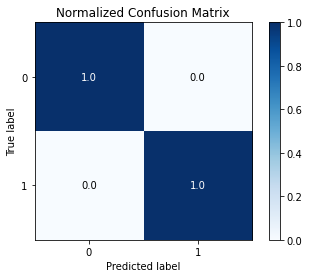

In [16]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

print("Accuracy: %.2f%%" % (scores[1]*100))

print(metrics.classification_report(y_test, predictions, target_names=[ 'no consensus', 'consensus']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [17]:
df_val = pd.read_csv('./data/sample_consensus.csv')
df_val

,Unnamed: 0,ad,consensus
0,0,virtually everyone knows america has a big ill...,1
1,1,everyone knows smoking causes cancer but did y...,1
2,2,virtually everyone knows america has a big ill...,1
3,3,everyone knows michigan auto insurance is the ...,1
4,4,canadians from every region have shared with m...,1
5,5,voters want free and fair elections when im go...,1
6,6,massive crowds last evening for the meeting on...,1
7,7,several questions have come my way since the a...,0
8,8,brad recently stopped by to talk to henry hint...,0
9,9,british chickens are typically fed on soya fro...,0


1/1 [==============================] - 0s 31ms/step - loss: 1.1065 - accuracy: 0.7143
Accuracy: 71.43%
confusion matrix:
[[2 3]
 [1 8]]



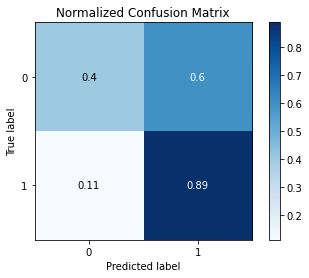

              precision    recall  f1-score   support

no consensus       0.67      0.40      0.50         5
   consensus       0.73      0.89      0.80         9

    accuracy                           0.71        14
   macro avg       0.70      0.64      0.65        14
weighted avg       0.71      0.71      0.69        14



In [18]:
norm_ = df_val['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

scores = model.evaluate(padded_, df_val['consensus'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

val_ = t.texts_to_sequences(norm_)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_, maxlen=MAX_SEQUENCE_LENGTH)
pred_ =  model.predict(padded_val)
df_val['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

print("confusion matrix:")
print(metrics.confusion_matrix(df_val['consensus'], df_val['predicted']  ))
print()

skplt.metrics.plot_confusion_matrix(df_val['consensus'], df_val['predicted'] , normalize=True)
plt.show()

print(metrics.classification_report(df_val['consensus'], df_val['predicted'] , target_names=[ 'no consensus', 'consensus']))